<a href="https://colab.research.google.com/github/geeancarlocarnevali/PairsTrading/blob/dev/PairsTrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [ ]:
def pairs_scan(prices,stock_pairs):
  result=[]
  for i,j in stock_pairs:
    data=np.log(prices[[i,j]].dropna())

    #Direction 1: i ~ j  (y=i, x=j)
    y1=data[i]
    x1=sm.add_constant(data[j])
    model1=sm.OLS(y1,x1).fit() #y1 = alpha + beta*x1 + e
    res1 = model1.resid
    p1 = adfuller(res1, regression='n',autolag='AIC')[1]
    a1 = model1.params['const']
    b1 = model1.params[j]

    #Direction 2: j ~ i  (y=j, x=i)
    y2=data[j]
    x2=sm.add_constant(data[i])
    model2=sm.OLS(y2,x2).fit() #y2 = alpha + beta*x2 + e
    res2 = model2.resid
    p2 = adfuller(res2,regression='n', autolag='AIC')[1]
    a2 = model2.params['const']
    b2 = model2.params[i]

    if p1<=p2:
      alpha=a1
      beta=b1
      pval=p1
      direction=f'{i}~{j}'
    else:
      alpha=a2
      beta=b2
      pval=p2
      direction=f'{j}~{i}'

    result.append({
            'pair': (i, j),
            'direction': direction,
            'alpha': alpha,
            'beta': beta,
            'adf_pvalue': pval,
            'n_obs': len(data)
        })

  out=pd.DataFrame(result).sort_values('adf_pvalue').reset_index(drop=True)
  return out

In [ ]:
def half_life(spread):
    """Ornstein–Uhlenbeck half-life estimate, bounded to [5, 252]."""
    s = spread.dropna()
    ds = s.diff().dropna()
    X = sm.add_constant(s.shift(1).dropna().loc[ds.index])
    res = sm.OLS(ds, X).fit()
    # params is a Series like [const, <spread_name>] — grab the 2nd element by position
    phi = res.params.iloc[1]
    if 1 + phi <= 0 or np.isnan(phi):
        return 63
    hl = int(-np.log(2) / np.log(1 + phi))
    return int(np.clip(hl, 5, 252))

In [ ]:
stock_list= [
    "SPY",   # S&P 500
    "IVV",   # S&P 500 (iShares)
    "VOO",   # S&P 500 (Vanguard)
    "QQQ",   # Nasdaq 100
    "XLK",   # Technology Select Sector
    "VGT",   # Vanguard Information Technology
    "IWM",   # Russell 2000
    "VTWO",  # Vanguard Russell 2000
    "EEM",   # iShares MSCI Emerging Markets
    "VWO",   # Vanguard FTSE Emerging Markets
    "DIA",   # Dow Jones Industrial Average ETF
    "IWB",   # Russell 1000
    "IWR",   # Russell Midcap
    "IJR",   # Russell 2000 Small-Cap
    "FXI",   # China Large-Cap
    "EWJ",   # Japan ETF
    "EWY",   # South Korea ETF
    "EWZ",   # Brazil ETF
    "HYG",   # High Yield Corporate Bonds
    "LQD",   # Investment Grade Bonds
    "TLT",   # 20+ Year Treasuries
    "IEF",   # 7–10 Year Treasuries
    "GLD",   # Gold
    "SLV",   # Silver
]
start_date='2010-01-01'
end_date='2025-08-31'

In [ ]:
prices=yf.download(stock_list,start=start_date,end=end_date,auto_adjust=False,interval='1d')['Adj Close']

[*********************100%***********************]  24 of 24 completed


In [ ]:
train_ratio=0.7

In [ ]:
split_idx = int(len(prices.index)*train_ratio)
prices_train = prices.iloc[:split_idx]

stock_pairs=[(stock_list[i],stock_list[j]) for i in range(len(stock_list)) for j in range(i+1,len(stock_list))] #generate the pairs

In [ ]:
ranked_pairs=pairs_scan(prices_train,stock_pairs)

cointegrated_pairs = ranked_pairs[ranked_pairs['adf_pvalue'] < 0.05].reset_index(drop=True)
display(cointegrated_pairs)

,pair,direction,alpha,beta,adf_pvalue,n_obs
0,"(VTWO, EWJ)",VTWO~EWJ,-1.949424,1.524167,0.000020,2576
1,"(IWM, EWJ)",IWM~EWJ,-1.403398,1.620381,0.000076,2757
2,"(FXI, EWJ)",FXI~EWJ,1.124887,0.624657,0.000080,2757
3,"(VGT, FXI)",FXI~VGT,2.420357,0.219165,0.000096,2757
4,"(XLK, FXI)",FXI~XLK,2.614071,0.223460,0.000118,2757
...,...,...,...,...,...,...
222,"(VWO, EWZ)",EWZ~VWO,1.693117,0.456974,0.039735,2757
223,"(LQD, SLV)",SLV~LQD,7.103740,-0.939485,0.041394,2757
224,"(SPY, IVV)",IVV~SPY,0.008914,0.998681,0.043656,2757
225,"(QQQ, XLK)",QQQ~XLK,0.793081,1.030937,0.047116,2757


In [ ]:
target_i,target_j= "VTWO", "DIA"
# Find the row where the unordered pair matches {EWZ, SLV}
row = cointegrated_pairs[
    cointegrated_pairs['pair'].apply(lambda p: set(p) == set((target_i, target_j)))
].head(1)

#guard: ensure target is cointegrated in TRAIN window
if row.empty:
    raise ValueError(f"Target pair {target_i}-{target_j} is not cointegrated at 5% in the training window.")

# The chosen direction was the one with lower ADF p-value in the screen
direction=row.iloc[0]['direction']  # either 'EWZ~SLV' or 'SLV~EWZ'

log_prices=np.log(prices[[target_i, target_j]]).dropna()
split=int(len(log_prices)*train_ratio)
if direction == f'{target_i}~{target_j}':
    y_name, x_name = target_i, target_j
else:
    y_name, x_name = target_j, target_i
# Fit OLS ONLY on the training window to avoid look-ahead bias
y_all = log_prices[y_name]
x_all = log_prices[x_name]
model = sm.OLS(y_all.iloc[:split], sm.add_constant(x_all.iloc[:split])).fit()
alpha, beta = model.params['const'], model.params[x_name]

# Cointegration spread: s = y - (alpha + beta*x)
spread = y_all - (alpha + beta * x_all)
# Estimate half-life on TRAINING spread only, then use that window length forward
hl = half_life(spread.iloc[:split])  #i am estimating how long it will take to for the spread to revert back to it's mean,
#and i using this value as rolling window
roll_mean = spread.rolling(hl, min_periods=hl).mean()#computing the rolling mean using as rolling window the above computed half-life
roll_std  = spread.rolling(hl, min_periods=hl).std()#computing the rolling spread using as rolling window the half-life
zscore = (spread - roll_mean) / roll_std#zscore measures how many standard deviations away from the rolling mean i am

In [200]:
ENTRY_Z=2 #I open a position when the zscore is 2 times the rolling mean
EXIT_Z=0.25 #I close a position when the zscore is 0.25 times the rolling mean (it means that it's getting closer to the rolling mean)
signals=pd.DataFrame(index=spread.index)#database having the same index as spread, it will store trading signal and positions
signals['z']=zscore

cross_up_long=(zscore<-ENTRY_Z) & (zscore.shift(1)>=-ENTRY_Z)#create a boolean variable to signal the opening of a long pos
#it will become true if the zscore is below the -entry_z at t and at t-1 was above it
cross_up_short= (zscore>ENTRY_Z) & (zscore.shift(1)<= ENTRY_Z)#create a signal to open a short position when the z score at t
#is above the entry_z and the previous day was below it
cross_exit_long=(zscore>=-EXIT_Z) #create a closing signal for the long position when at t the zscore is above the -z_exit
cross_exit_short=(zscore<=EXIT_Z) #create a closing signal for the short position when at t the zscore i below the z_exit

pos = pd.Series(0, index=zscore.index, dtype=int)

for t in range(1, len(zscore)):
    prev=pos.iloc[t-1]
    if prev == 0:
        if cross_up_long.iloc[t]:#if at t-1 no trade and at t the boolean for the opening long signal is true then i assign a value of 1 at the position
            pos.iloc[t] = 1
        elif cross_up_short.iloc[t]:#if at t-1 no trade and at t the boolean for the opening short signal is true then i assign a value of -1 at the position
            pos.iloc[t] = -1
        else:
            pos.iloc[t] = 0 #if at t-1 no trade and at t no signal for trading i remain flat
    elif prev == 1:
        pos.iloc[t] = 0 if cross_exit_long.iloc[t] else 1 #if at t-1 there was a long position open and the boolean for closing the long is active i assign the value of 0 otherewise i keep
        #the long position open
    else:
        pos.iloc[t] = 0 if cross_exit_short.iloc[t] else -1 #if at t-1 there was a short position open (-1) and at t the boolean for closing the short is active i close the position, if boolean
        #is not active i keep the short going

signals['position'] = pos

In [ ]:
t0=log_prices.index[split]#t0 is the date at which the testing sample begins
pos.loc[:t0]=0#to avoid carrying over the position from the the training test, the first position is set as 0 (no position in place)

px_test=prices.loc[t0:,[y_all,x_name]]#extracting the prices fron t0 afterwards only for the tickers decided
log_rets=np.log(px_test).diff().dropna()

# positions (delay-1, no carry-in)
pos_test=pd.Series(pos, index=log_rets.index).shift(1).fillna(0)#creating subset of positions from the original pos series
#and align it to the log_rets for testing the algo, since the trades actually depends on t-1 day i shift everything 1 day foward
#with this i am ensuring that the position used for computing the pnl at t is based on the informations available at t-1
pos_test.iloc[0] = 0#ensuring that the backtesting starts from 0

z_test=signals['z'].reindex(log_rets.index)#aligns the zscore, it ensures that the zscore is available for the same dates
#as the log returns in the test window

# --- timeout & z-stop overlay ---
raw=pos_test.copy().astype(int)#holds the theoretical positions i want to take
final=pos_test.copy().astype(int)#hold the actual positions taken after volatility and timeout closing are taken into consideration

bars_held=0#keeps track of how many trading day a position has been held continuously
curr=0#track the actual trading position that we are holding after the rules about volatility and timeout are applied
for i in range(len(final)):
    intended=raw.iloc[i]#my theoretical trading position
    zt=z_test.iloc[i]#it get my zsscore at my current date
    if curr==0:
        curr=intended #if the actual trading strategy at t is 0 then assign the theoretical trading value
        bars_held=0 if curr==0 else 1#if i haven't done any trade the bar_held counter is still zero otherwise set 1
        #(because it means that i just entered a trade)
    else:
        bars_held+=1 #since curr =\= is different from zero I increment the counter for the days the trade is being held
        exit_by_timeout=bars_held>=2*hl#if the position is being held for twice the hl(the rolling window) close the position no matter what
        exit_by_stop=abs(zt)>4#if the volatilty of z score increase by 4 times then close the position (it's a stop loss)
        exit_by_logic=(intended==0)#if the theoretical strategy signal a closing then close

        if exit_by_timeout or exit_by_stop or exit_by_logic:
            curr= 0 #if an exit condition is met the trade is closed
            bars_held= 0#since no trade is inplace set the holding period of the trade back to zero

    final.iloc[i]= curr

pos_test= final#the actual trading position that is being implemented

#computing the pnl
gross=1.0+abs(beta)#total capital employed in the pair trade for every amount of $(€) of the y_stock bought/sold
#if long 1 unit of of y_stock it means that we are short 1 unit of x_stock
pair_ret=pos_test*(log_rets[y_name]-beta*log_rets[x_name])/gross#computing the daily profit/loss from the strategy

# costs from weight changes
cost_bps= 0.0005
w_y,w_x=(pos_test/gross),(-beta*pos_test/gross)
turnover=w_y.diff().abs().fillna(0) + w_x.diff().abs().fillna(0)#total amount of capital that had to be adjusted due to
#changes in the positiom
costs=turnover * cost_bps

# net cumulative return
net=(pair_ret-costs).fillna(0)
cum = np.exp(net.cumsum())#cumulative net return
entries=((pos_test.shift(1)==0) & (pos_test!= 0)).sum()#number of trades executed (opening long/short)
test_sharpe = np.sqrt(252) * net.mean() / net.std() if net.std() > 0 else np.nan #annualized sharpe ratio
stats = {
    "half_life_days": hl,#estimated times it takes for the spread to revert back to the mean
    "test_CAGR_%": float((cum.iloc[-1]**(252/len(cum))-1)*100) if len(cum) > 1 else np.nan,#compounded annual growth rate
    "test_Sharpe": float(test_sharpe),#sharpe ratio
    "test_MaxDD_%": float(((cum/cum.cummax())-1).min()*100) if len(cum) else np.nan,#max drawdown
    "n_trading_days_test": int(len(net)),#trading days in the test period
    "trades": int(entries),
}
stats

{'half_life_days': 126,
 'test_CAGR_%': 2.03781542799617,
 'test_Sharpe': 0.37880790171479906,
 'test_MaxDD_%': -8.453222024476592,
 'n_trading_days_test': 1127,
 'trades': 10}

In [201]:
t0

Timestamp('2021-03-05 00:00:00')

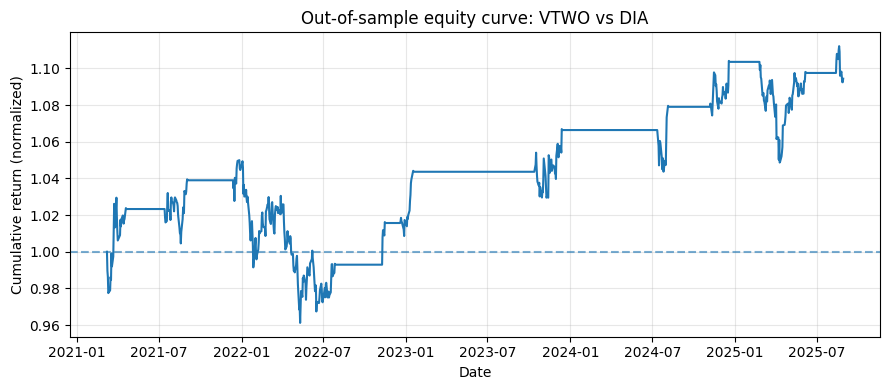

In [ ]:
plt.figure(figsize=(9,4))
plt.plot(cum.index, cum.values, lw=1.5)
plt.axhline(1.0, ls='--', alpha=0.6)
plt.title(f'Out-of-sample equity curve: {y_name} vs {x_name}')
plt.ylabel('Cumulative return (normalized)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()

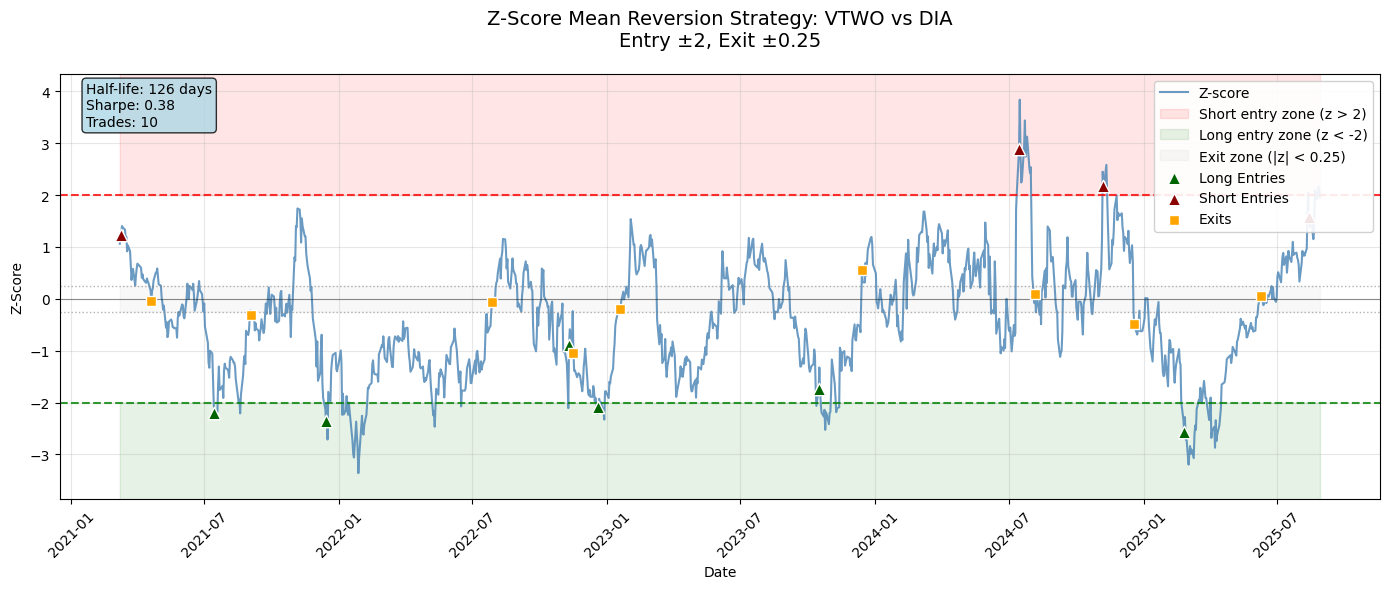

In [ ]:
# --- find trade entry/exit timestamps (TEST window, NaN-safe) ---

# 1) z in test window (drop initial NaNs from rolling stats)
z_test = signals['z'].reindex(log_rets.index).dropna()

# 2) positions for plotting only (don't modify pos_test used for PnL)
pos_plot = pos_test.reindex(z_test.index).fillna(0).astype(int)

# 3) state-change detection; first bar cannot be an event
chg = pos_plot.ne(pos_plot.shift(1))
chg.iloc[0] = False

entries_idx = pos_plot.index[chg & (pos_plot != 0)]  # 0 -> ±1
exits_idx   = pos_plot.index[chg & (pos_plot == 0)]  # ±1 -> 0


# ==== robust plotting ====
import matplotlib.dates as mdates
plt.figure(figsize=(14, 6))

ymin = min(z_test.min(), -ENTRY_Z) - 0.5
ymax = max(z_test.max(),  ENTRY_Z) + 0.5
plt.ylim(ymin, ymax)

plt.plot(z_test.index, z_test.values, lw=1.5, color='steelblue', label='Z-score', alpha=0.8)

plt.fill_between(z_test.index,  ENTRY_Z,  ymax, alpha=0.1, color='red',
                 label=f'Short entry zone (z > {ENTRY_Z})')
plt.fill_between(z_test.index,  ymin,   -ENTRY_Z, alpha=0.1, color='green',
                 label=f'Long entry zone (z < -{ENTRY_Z})')
plt.fill_between(z_test.index, -EXIT_Z,  EXIT_Z, alpha=0.05, color='gray',
                 label=f'Exit zone (|z| < {EXIT_Z})')

plt.axhline( ENTRY_Z, ls='--', alpha=0.8, color='red',   lw=1.5)
plt.axhline(-ENTRY_Z, ls='--', alpha=0.8, color='green', lw=1.5)
plt.axhline( EXIT_Z, ls=':',  alpha=0.6, color='gray',  lw=1)
plt.axhline(-EXIT_Z, ls=':',  alpha=0.6, color='gray',  lw=1)
plt.axhline(0,       ls='-',  alpha=0.4, color='black', lw=0.8)

# classify entries by sign of z at the entry time
long_idx  = entries_idx[z_test.loc[entries_idx] < 0]
short_idx = entries_idx[z_test.loc[entries_idx] > 0]

plt.scatter(long_idx,  z_test.loc[long_idx],  marker='^', s=80, color='darkgreen',
            edgecolor='white', linewidth=1, label='Long Entries',  zorder=5)
plt.scatter(short_idx, z_test.loc[short_idx], marker='^', s=80, color='darkred',
            edgecolor='white', linewidth=1, label='Short Entries', zorder=5)
plt.scatter(exits_idx, z_test.loc[exits_idx], marker='s', s=60, color='orange',
            edgecolor='white', linewidth=1, label='Exits', zorder=5)

plt.text(0.02, 0.98, f'Half-life: {hl} days\nSharpe: {stats["test_Sharpe"]:.2f}\nTrades: {stats["trades"]}',
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.title(f'Z-Score Mean Reversion Strategy: {y_name} vs {x_name}\n'
          f'Entry ±{ENTRY_Z}, Exit ±{EXIT_Z}', fontsize=14, pad=20)
plt.ylabel('Z-Score'); plt.xlabel('Date')
plt.grid(True, alpha=0.3)

# de-dupe legend
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), loc='upper right', framealpha=0.9)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ==== end ====
